In [1]:
!pip install datasets[vision]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached datasets-2.2.2-py3-none-any.whl (346 kB)
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [16]:
train_folder = "../train-val/Training/"
test_folder = "../test/Test/"
import torch.utils.data as data
from datasets import load_dataset
ds = load_dataset("imagefolder", ignore_verifications=True, data_files={"train": f"{train_folder}**", "test": f"{test_folder}**"})

Resolving data files:   0%|          | 0/39375 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/8617 [00:00<?, ?it/s]

Using custom data configuration default-320a3a01cff974fc
Reusing dataset image_folder (/home/ubuntu/.cache/huggingface/datasets/image_folder/default-320a3a01cff974fc/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597)


  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
import datasets
train_valid = ds['train'].train_test_split(test_size=0.2)
ds = datasets.DatasetDict({
    'train': train_valid['train'],
    'val': train_valid['test'],
    'test': ds['test']
})
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 31500
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 7875
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 8617
    })
})

In [18]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


In [19]:
model_name = "resnet"
num_classes = 2
batch_size = 8
num_epochs = 15
feature_extract = True
data_dir = "train-val/Training"
test_dir = "test/Test"
percent_val = 0.1
save_path = "saved-models"

In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [21]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [22]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [26]:
image_datasets = {}
orig_set = datasets.ImageFolder(train_folder)
n = len(orig_set)
n_val = int(percent_val * n)
train_dataset, val_dataset = random_split(orig_set, [n-n_val, n_val])
val_dataset.dataset.transform = data_transforms["val"]
train_dataset.dataset.transform = data_transforms["train"]
image_datasets["val"] = val_dataset
image_datasets["train"] = train_dataset
image_datasets["test"] = datasets.ImageFolder(test_folder, data_transforms["test"])

# Create training, validation, and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [36]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
torch.save(model_ft.state_dict(), os.path.join(os.path.join(save_path, "resnet"), "resnet.pth"))

Epoch 0/14
----------
train Loss: 0.0629 Acc: 0.9779
val Loss: 0.0119 Acc: 0.9952

Epoch 1/14
----------
train Loss: 0.0632 Acc: 0.9776
val Loss: 0.0141 Acc: 0.9929

Epoch 2/14
----------
train Loss: 0.0620 Acc: 0.9775
val Loss: 0.0117 Acc: 0.9967

Epoch 3/14
----------
train Loss: 0.0624 Acc: 0.9783
val Loss: 0.0151 Acc: 0.9936

Epoch 4/14
----------
train Loss: 0.0647 Acc: 0.9773
val Loss: 0.0116 Acc: 0.9964

Epoch 5/14
----------
train Loss: 0.0619 Acc: 0.9780
val Loss: 0.0118 Acc: 0.9957

Epoch 6/14
----------
train Loss: 0.0638 Acc: 0.9778
val Loss: 0.0111 Acc: 0.9957

Epoch 7/14
----------
train Loss: 0.0650 Acc: 0.9766
val Loss: 0.0126 Acc: 0.9954

Epoch 8/14
----------
train Loss: 0.0687 Acc: 0.9767
val Loss: 0.0118 Acc: 0.9954

Epoch 9/14
----------
train Loss: 0.0636 Acc: 0.9774
val Loss: 0.0121 Acc: 0.9947

Epoch 10/14
----------
train Loss: 0.0709 Acc: 0.9756
val Loss: 0.0200 Acc: 0.9903

Epoch 11/14
----------
train Loss: 0.0646 Acc: 0.9770
val Loss: 0.0129 Acc: 0.9939

Ep

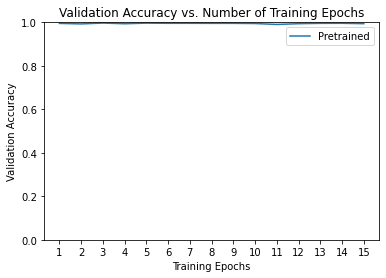

In [39]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method
ohist = []

ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [40]:
# check accuracy on test set
def test_accuracy(loader, model, is_val):
    if is_val:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))   

In [41]:
test_accuracy(dataloaders_dict["val"], model_ft, True)
test_accuracy(dataloaders_dict["test"], model_ft, False)

Checking accuracy on validation set
Got 3924 / 3937 correct (99.67)
Checking accuracy on test set
Got 6431 / 8617 correct (74.63)


In [28]:
# initialize densenet model
# Initialize the model for this run
model_name = "densenet"
model_ft_densenet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft_densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [29]:
# Send the model to GPU
model_ft_densenet = model_ft_densenet.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_densenet.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_densenet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_densenet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


In [30]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft_densenet, hist_densenet = train_model(model_ft_densenet, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
torch.save(model_ft_densenet.state_dict(), os.path.join(os.path.join(save_path, "densenet"), "densenet.pth"))

Epoch 0/14
----------
train Loss: 0.1060 Acc: 0.9608
val Loss: 0.0202 Acc: 0.9929

Epoch 1/14
----------
train Loss: 0.0741 Acc: 0.9730
val Loss: 0.0267 Acc: 0.9911

Epoch 2/14
----------
train Loss: 0.0711 Acc: 0.9750
val Loss: 0.0125 Acc: 0.9962

Epoch 3/14
----------
train Loss: 0.0621 Acc: 0.9777
val Loss: 0.0126 Acc: 0.9964

Epoch 4/14
----------
train Loss: 0.0691 Acc: 0.9765
val Loss: 0.0175 Acc: 0.9947

Epoch 5/14
----------
train Loss: 0.0583 Acc: 0.9800
val Loss: 0.0099 Acc: 0.9970

Epoch 6/14
----------
train Loss: 0.0593 Acc: 0.9784
val Loss: 0.0224 Acc: 0.9926

Epoch 7/14
----------
train Loss: 0.0644 Acc: 0.9765
val Loss: 0.0104 Acc: 0.9975

Epoch 8/14
----------
train Loss: 0.0592 Acc: 0.9794
val Loss: 0.0133 Acc: 0.9959

Epoch 9/14
----------
train Loss: 0.0603 Acc: 0.9793
val Loss: 0.0164 Acc: 0.9947

Epoch 10/14
----------
train Loss: 0.0552 Acc: 0.9802
val Loss: 0.0114 Acc: 0.9954

Epoch 11/14
----------
train Loss: 0.0569 Acc: 0.9805
val Loss: 0.0116 Acc: 0.9972

Ep

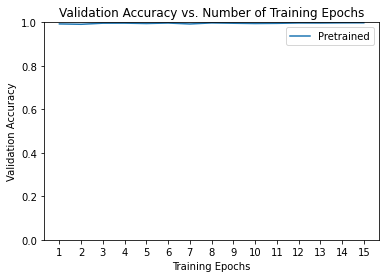

In [31]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method
ohist = []

ohist = [h.cpu().numpy() for h in hist_densenet]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [32]:
test_accuracy(dataloaders_dict["val"], model_ft_densenet, True)
test_accuracy(dataloaders_dict["test"], model_ft_densenet, False)

NameError: name 'test_accuracy' is not defined